In [72]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
import numpy as np
import itertools
import seaborn
from sklearn.metrics import roc_auc_score
from experiments.libs import loaders
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score
from xgboost import XGBModel

from lightgbm import LGBMClassifier


from libs.loaders import load_bci
from itertools import zip_longest
from copy import deepcopy

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
pipeline_steps = [('scale', StandardScaler())]
continuous_pipeline = Pipeline(steps=pipeline_steps)

In [74]:
featurisers = [('continuous', continuous_pipeline)]

In [75]:
xgb_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', XGBClassifier(max_depth=2, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                gamma=0.1,
                                                                subsample=1))]) 

In [76]:
lgbm_clf_pipeline = Pipeline(steps=[('features', FeatureUnion(featurisers)),
                                          ('clf', LGBMClassifier(max_depth=2, 
                                                                learning_rate=0.1, 
                                                                scale_pos_weight=2,
                                                                n_estimators=100,
                                                                subsample=1))]) 

In [77]:
X, y, X_test, y_test = load_bci()

In [78]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [79]:
def run_train_retrain_comparison(model, X, y, X_test, y_test):
    retrain_model = deepcopy(model)
    historical_X = [X]
    historical_y = [y]
    prev_size = X.shape[0]
    train_auc=[]
    retrain_auc=[]
    for X_chunk, y_chunk in  zip(grouper(X_test, 15*12), grouper(y_test, 15*12)):
        X_chunk_array = np.array(X_chunk)
        y_chunk_array = np.array(y_chunk)
        
        try: # TODO: Fix grouper
            y_pred = model.predict_proba(X_chunk_array)
            train_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
            print('Train ', train_auc[-1])

            y_pred = retrain_model.predict_proba(X_chunk_array)
            retrain_auc.append(roc_auc_score(y_chunk_array, y_pred[:, 1]))
            print('Retrain ', retrain_auc[-1])

            historical_X.append(X_chunk_array)
            historical_y.append(y_chunk_array)

            new_train_X  = np.concatenate(historical_X)
            retrain_model.fit(new_train_X, np.concatenate(historical_y))
        except:
            print('Finished')
            print(X_chunk_array.shape)
            print(y_chunk_array.shape)
        
    return pd.DataFrame({
        'train_auc':train_auc,
        'retrain_auc':retrain_auc
    })



In [80]:
xgb_clf_pipeline.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0...logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=2, seed=0, silent=True, subsample=1))])

In [81]:
df = run_train_retrain_comparison(xgb_clf_pipeline, X, y, X_test, y_test)

Train  0.824853864473
Retrain  0.824853864473
Train  0.76726448155
Retrain  0.75159760874
Train  0.738666666667
Retrain  0.742
Train  0.728847703465
Retrain  0.714544721998
Train  0.77780016116
Retrain  0.778807413376
Train  0.757306776359
Retrain  0.727430179693
Train  0.723749729379
Retrain  0.735007577398
Train  0.832647759255
Retrain  0.828967308941
Train  0.796
Retrain  0.808
Train  0.759038752977
Retrain  0.762069712059
Train  0.754895897753
Retrain  0.775097917955
Train  0.692640692641
Retrain  0.696557410843
Train  0.727443609023
Retrain  0.734727443609
Train  0.815111495995
Retrain  0.814462004763
Train  0.705640280804
Retrain  0.706366497216
Train  0.752417405318
Retrain  0.735092667204
Train  0.769214527027
Retrain  0.758234797297
Train  0.690373118945
Retrain  0.680890538033
Train  0.746888888889
Retrain  0.748666666667
Train  0.619047619048
Retrain  0.603174603175
Train  0.727555555556
Retrain  0.773555555556
Train  0.756440788049
Retrain  0.753842823122
Train  0.729378653

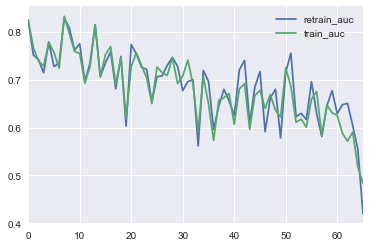

In [85]:
df.plot()

In [86]:
df.mean()

retrain_auc    0.689196
train_auc      0.683177
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


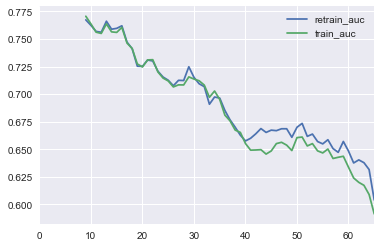

In [87]:
pd.rolling_mean(df, 10).plot()

In [88]:
lgbm_clf_pipeline.fit(X,y)

Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]))],
       transformer_weights=None)), ('clf', LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, drop_rate=0.1,
        is_un...   subsample_for_bin=50000, subsample_freq=1, uniform_drop=False,
        xgboost_dart_mode=False))])

In [89]:
df = run_train_retrain_comparison(lgbm_clf_pipeline, X, y, X_test, y_test)

Train  0.81705996969
Retrain  0.81705996969
Train  0.762935477221
Retrain  0.75221603793
Train  0.730222222222
Retrain  0.756222222222
Train  0.718372280419
Retrain  0.728646253022
Train  0.774174053183
Retrain  0.770145044319
Train  0.758172764668
Retrain  0.737172548171
Train  0.696254600563
Retrain  0.707295951505
Train  0.831348776792
Retrain  0.81467850184
Train  0.785777777778
Retrain  0.811333333333
Train  0.742151980948
Retrain  0.757523273436
Train  0.755720470006
Retrain  0.754483611626
Train  0.702535559678
Retrain  0.691403834261
Train  0.746240601504
Retrain  0.722744360902
Train  0.802121671357
Retrain  0.823121887855
Train  0.677075768579
Retrain  0.691358024691
Train  0.742546333602
Retrain  0.745366639807
Train  0.760768581081
Retrain  0.760768581081
Train  0.690579262008
Retrain  0.704390847248
Train  0.768888888889
Retrain  0.760222222222
Train  0.615749330035
Retrain  0.588332302618
Train  0.713555555556
Retrain  0.754222222222
Train  0.759688244209
Retrain  0.73544

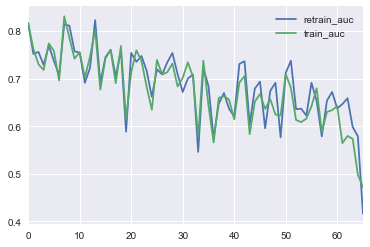

In [90]:
df.plot()

In [91]:
df.mean()

retrain_auc    0.688409
train_auc      0.679028
dtype: float64

/home/hoaphumanoid/anaconda3/envs/strata/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,min_periods=1,center=False).mean()
  if __name__ == '__main__':


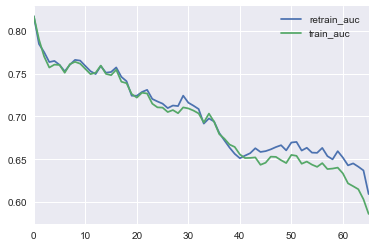

In [95]:
pd.rolling_mean(df, 10, min_periods=1).plot()